<h2>
<i>The 12% Solution</i>
</h2>

<p>
This Jupyter notebook investigates a stock market trading algorithm that is described in the
(short) book <i>The 12% Solution: Earn A 12% Average Annual Return On Your Money, Beating
The S&P 500</i> by David Alan Carter.  According to the book this algorithm, which is
 referred to as "ETF rotation", yields a 12% return, on average.
</p>
<p>
This Jupyter notebook is saved on GitHub: https://github.com/IanLKaplan/twelve_percent
</p>
<p>
In this Jupyter notebook I have tried to reproduce the results described in
<i>The 12% solution</i>.
</p>
<p>
The book <i>The 12% Solution</i> is targeted at a readership that is not using analytical
tools like Python, Jupyter or R.  Following the proposed algorithm the reader trades one
of four equity ETFs, two bond ETFs or a cash ETF. The analysis of past ETF
performance described in <i>The 12% Solution</i> is performed using on-line tools.
</p>
<p>
The algorithm outlined in <i>The 12% solution</i> is referred a momentum algorithm.
The ETF with the highest three month return is chosen from the equity or bond
ETF set for the next month. The success of this approach is based on the ETF performance
in the next month being correlated with the past three month return.
</p>
<p>
<i>The 12% Soluton</i> portfolio allocates 60% of the portfolio to equity (stock) ETFs
and 40% in bonds.  The bond portion of the portfolio is allocated to either a US Treasury bond
ETF or to a corporate high yield (sometimes called junk bonds) ETF, depending on the
relative yield for the previous three months.
</p>
<p>
In this notebook the results from <i>The 12% Solution</i> are reproduced.  The notebook
also investigates whether these results can be improved upon.
</p>
<p>
The ETFs used in <i>The 12% Solution</i> are highly correlated.  This notebook explores
whether a larger ETF set would improve performance since there may be ETFs that have
better performance in the previous quarter than the four equity ETFs.
</p>

<h2>
The ETF Rotation Set
</h2>
<h3>
Equity ETFs
</h3>
<p>
In <i>The 12% Solution</i> there are four ETFs that are used in rotation, two bond funds
and one ETF (SHY) that is used as a proxy for "cash" (e.g., an asset at the risk free rate).
</p>
<ul>
<li>
<p>
IWM: iShares Russell 2000 ETF
</p>
<p>
IWM tracks a market-cap-weighted index of US small-cap stocks. The index selects
stocks ranked 1,001-3,000 by market cap.
</p>
<p>
Inception date: 5/22/2000
</p>
</li>
<li>
<p>
MDY: SPDR S&P Midcap 400 ETF Trust
</p>
<p>
MDY tracks a market-cap-weighted index of midcap US companies.
</p>
<p>
Inception date: 5/04/1995
</p>
</li>
<li>
<p>
QQQ: Invesco QQQ Trust
</p>
<p>
QQQ tracks a modified-market-cap-weighted index of 100 NASDAQ-listed stocks.
</p>
<p>
Inception date: 3/10/1999
</p>
</li>
<li>
<p>
SPY: SPDR S&P 500 ETF Trust
</p>
<p>
SPY tracks a market-cap-weighted index of US large- and midcap stocks selected by
the S&P Committee (e.g., S&P 500).
</p>
<p>
Inception date: Jan 22, 1993
</p>
</li>
</ul>
<h3>
Bond ETFs
</h3>
<ul>
<li>
<p>
TLT: iShares 20+ Year Treasury Bond ETF
</p>
<p>
TLT tracks a market-weighted index of debt issued by the US Treasury
with remaining maturities of 20 years or more.
</p>
<p>
Inception date: 7/22/2002
</p>
</li>
<li>
<p>
JNK: SPDR Bloomberg High Yield Bond ETF
</p>
<p>
JNK tracks a market-weighted index of highly liquid, high-yield, US
dollar-denominated corporate bonds.
</p>
<p>
Inception date: 11/28/2007
</p>
</li>
</ul>
<h3>
Cash Proxy
</h3>
<ul>
<li>
<p>
SHY: iShares 10-20 Year Treasury Bond ETF
</p>
<p>
SHY tracks a market weighted index of debt issued by the US Treasury
with 1-3 years remaining to maturity. Treasury STRIPS are excluded.
</p>
<p>
Inception date: 07/22/2002
</p>
</li>
</ul>
<p>
In <i>The 12% Solution</i> the backtest time period starts January 2008.
The inception period for the JNK corporate high yield bond fund is
November 18, 2007.  To simplify the software in this notebook, the start period is
March 3, 2008 (prividing a look-back period over December 2007, January 2008 and
February 2008).
</p>

In [416]:
from datetime import datetime, timedelta
from numpy import sqrt
from tabulate import tabulate
from typing import List, Tuple
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.indexes.datetimes import DatetimeIndex
from dateutil.relativedelta import relativedelta
import numpy as np
from pathlib import Path
import tempfile

pd.options.mode.chained_assignment = 'raise'

def get_market_data(file_name: str,
                    data_col: str,
                    symbols: List,
                    data_source: str,
                    start_date: datetime,
                    end_date: datetime) -> pd.DataFrame:
    """
      file_name: the file name in the temp directory that will be used to store the data
      data_col: the type of data - 'Adj Close', 'Close', 'High', 'Low', 'Open', Volume'
      symbols: a list of symbols to fetch data for
      data_source: yahoo, etc...
      start_date: the start date for the time series
      end_date: the end data for the time series
      Returns: a Pandas DataFrame containing the data.

      If a file of market data does not already exist in the temporary directory, fetch it from the
      data_source.
    """
    temp_root: str = tempfile.gettempdir() + '/'
    file_path: str = temp_root + file_name
    temp_file_path = Path(file_path)
    file_size = 0
    if temp_file_path.exists():
        file_size = temp_file_path.stat().st_size

    if file_size > 0:
        close_data = pd.read_csv(file_path, index_col='Date')
    else:
        panel_data: pd.DataFrame = data.DataReader(symbols, data_source, start_date, end_date)
        close_data: pd.DataFrame = panel_data[data_col]
        close_data.to_csv(file_path)
    assert len(close_data) > 0, f'Error reading data for {symbols}'
    return close_data


plt.style.use('seaborn-whitegrid')

equity_etfs = ['IWM', 'MDY', 'QQQ', 'SPY']
bond_etfs = ['JNK', 'TLT']
cash_etf = 'SHY'

data_source = 'yahoo'
# The start date is the date used in the examples in The 12% Solution
# yyyy-mm-dd
start_date_str = '2008-03-03'
start_date: datetime = datetime.fromisoformat(start_date_str)
look_back_date_str = '2007-12-03'
look_back_date: datetime = datetime.fromisoformat(look_back_date_str)
end_date: datetime = datetime.today() - timedelta(days=1)
# get rid of any time component
end_date = datetime(end_date.year, end_date.month, end_date.day)

etf_adjclose_file = 'equity_etf_adjclose'
equity_adj_close = get_market_data(file_name=etf_adjclose_file,
                                data_col='Adj Close',
                                symbols=equity_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

shy_adjclose_file = 'shy_adjclose'
shy_adj_close = get_market_data(file_name=shy_adjclose_file,
                                data_col='Adj Close',
                                symbols=[cash_etf],
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

fixed_income_adjclose_file = "fixed_income_adjclose"
fixed_income_adjclose = get_market_data(file_name=fixed_income_adjclose_file,
                                data_col='Adj Close',
                                symbols=bond_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

# 13-week yearly treasury bond quote
risk_free_asset = '^IRX'
rf_file_name = 'rf_adj_close'
# The bond return is reported as a yearly return percentage
rf_adj_close = get_market_data(file_name=rf_file_name,
                                data_col='Adj Close',
                                symbols=[risk_free_asset],
                                data_source=data_source,
                                start_date=start_date,
                                end_date=end_date)

# The ^IRX interest rate is reported as a yearly percentage rate.
# Convert this to a daily interest rate
rf_adj_rate_np: np.array = np.array( rf_adj_close.values ) / 100
rf_daily_np = ((1 + rf_adj_rate_np) ** (1/360)) - 1
rf_daily_df: pd.DataFrame = pd.DataFrame( rf_daily_np, index=rf_adj_close.index, columns=['^IRX'])

corr_mat = round(equity_adj_close.corr(), 3)


<h3>
ETF Correlation
</h3>
<p>
In <i>The 12% Solution</i> algorithm the ETF with the highest return in the previous
three months is selected, unless the return is less than the return of SHY, in which case
SHY is selected.
</p>
<p>
One possible problem with this rotation algorith is that the ETFs are highly
correlated. One ETF may do somewhat better than the other ETFs, but they are all
market ETFs and are likely to have similar performance.  If the "market" is down
then all of the ETFs will probably be down.  The ETFs are also likely to have
similar returns.
</p>
<p>
The correlation matrix below shows the correlation between the equity ETFs.
</p>

In [417]:
print(tabulate(corr_mat, headers=[*corr_mat.columns], tablefmt='fancy_grid'))

╒═════╤═══════╤═══════╤═══════╤═══════╕
│     │   IWM │   MDY │   QQQ │   SPY │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│ IWM │ 1     │ 0.997 │ 0.953 │ 0.981 │
├─────┼───────┼───────┼───────┼───────┤
│ MDY │ 0.997 │ 1     │ 0.954 │ 0.985 │
├─────┼───────┼───────┼───────┼───────┤
│ QQQ │ 0.953 │ 0.954 │ 1     │ 0.988 │
├─────┼───────┼───────┼───────┼───────┤
│ SPY │ 0.981 │ 0.985 │ 0.988 │ 1     │
╘═════╧═══════╧═══════╧═══════╧═══════╛


<p>
The high correlation between the ETFs suggests two areas that are worth investigating:
</p>
<ul>
<li>
<p>
Would the financial performance be similar if only a single ETF were used. For example,
SPY?
</p>
</li>
<li>
<p>
If a larger ETF universe is used ETFs with lower correlation might be selected
resulting in better performance.
</p>
</li>
</ul>

<h3>
Asset return over time
</h3>

<p>
The simple return for a time period <i>t</i> is:
</p>

$\ R_t = \large \frac{R_t - R_{t-1}}{R_{t-1}} = \frac{R_t}{R_{t-1}} - 1$

The portfolio value calculated via continuously compounded returns is:

$\ portfolio\ value\ = V_t = V_{t-1} + V_{t-1} \times R_{t} $

where $\ V_{0} = initial\ investment $

In [418]:
def findDateIndex(date_index: DatetimeIndex, search_date: datetime) -> int:
    '''
    In a DatetimeIndex, find the index of the date that is nearest to search_date.
    This date will either be equal to search_date or the next date that is less than
    search_date
    '''
    index: int = -1
    i = 0
    date_t = datetime.today()
    for i in range(0, len(date_index)):
        date_t = date_index[i]
        if type(date_t) == str:
            date_t = datetime.fromisoformat(date_t)
        if date_t >= search_date:
            break
    if date_t > search_date:
        index = i - 1
    elif date_t == search_date:
        index = i
    return index


asset_adj_close = equity_adj_close.copy()
asset_adj_close[shy_adj_close.columns[0]] = shy_adj_close

start_date_ix = findDateIndex(asset_adj_close.index, start_date)

assert start_date_ix >= 0


def chooseAsset(start: int, end: int, asset_set: pd.DataFrame) -> pd.DataFrame:
    '''
    Choose an ETF asset or cash for a particular range of close price values.
    The ETF and cash time series should be contained in a single DataFrame
    The function returns a DataFrame with the highest returning asset for the
    period.
    '''
    rslt_df = asset_set
    asset_name = asset_set.columns[0]
    if asset_set.shape[1] > 1:
        ret_list = []
        start_date = asset_set.index[start]
        end_date = asset_set.index[end]
        for asset in asset_set.columns:
            ts = asset_set[asset][start:end+1]
            start_val = ts[0]
            end_val = ts[-1]
            r = (end_val/start_val) - 1
            ret_list.append(r)
        ret_df = pd.DataFrame(ret_list).transpose()
        ret_df.columns = asset_set.columns
        column = ret_df.idxmax(axis=1)[0]
        asset_name = column
        rslt_df = pd.DataFrame(asset_set[column])
    return rslt_df

<h3>
Start Period
</h3>

<p>
<i>The 12% Solution</i> ETF rebalancing algorithm picks the ETF with the higest
three month return or SHY (the proxy for cash).  The starting date is the first trading
day in March 2008, March 3, 2008. The start of the look-back period is December 1, 2007.
</p>
The stock part of the portfolio (60%) is invested
in the chosen asset for the next month and the portfolio is rebalanced again.
</p>
<p>
The 40% of the portfolio that is held in bonds is invested in either TLT (the Treasury
ETF) or JNK (the high yield corporate bond ETF).
</p>

In [419]:
start_date_ix = findDateIndex(asset_adj_close.index, start_date)
ts_df = chooseAsset(0, start_date_ix, asset_adj_close)

print(f'The asset for the first three month period will be {ts_df.columns[0]}')

The asset for the first three month period will be SHY


To check that the code is picking the right asset, we can look at the plot showing
the percentage return for each of the assets.

Text(0, 0.5, 'Return Percent')

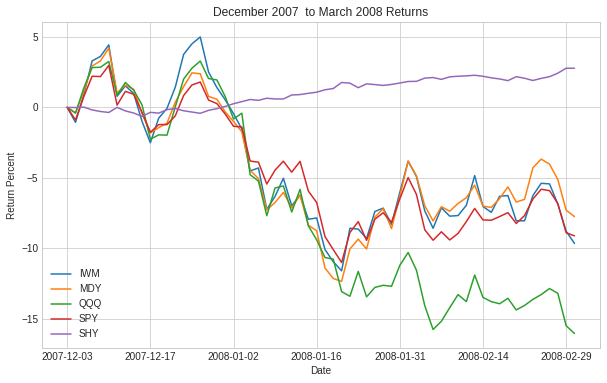

In [420]:
def percent_return_df(start_date: datetime, end_date: datetime, prices_df: pd.DataFrame) -> pd.DataFrame:
    def percent_return(time_series: pd.Series) -> pd.Series:
        return list(((time_series[i] / time_series[0]) - 1.0 for i in range(0, len(time_series))))


    date_index = prices_df.index
    start_ix = findDateIndex(date_index, start_date)
    end_ix = findDateIndex(date_index, end_date)
    period_df = prices_df[:][start_ix:end_ix+1]
    period_return_df = pd.DataFrame()
    for col in period_df.columns:
        return_series = percent_return(period_df[col])
        period_return_df[col] = return_series
    period_return_df.index = period_df.index
    return_percent_df = round(period_return_df * 100, 2)
    return return_percent_df

quarter_return_df = percent_return_df(start_date=look_back_date, end_date=start_date, prices_df=asset_adj_close)

ax = quarter_return_df.plot(grid=True, title='December 2007  to March 2008 Returns', figsize=(10,6))
ax.set_ylabel('Return Percent')

<h3>
ETF Rotation Algorithm
</h3>

<ol>
<li>
Create a DataFrame that constains adjusted close price for the the ETF universe and the
cash ETF. This will be referred to as the asset DataFrame
</li>
<li>
<p>
Choose a start date that has three trading months of past data.
</p>
<p>
From start date to the current date, stepping by one trading month
</p>
<ol>
<li>
Choose the asset with the highest return over the past three trading months
from the asset DataFrame (e.g., an equity or the cash ETF).
</li>
<li>
Calculate the daily return for the selected asset for one month forward from the start date.
</li>
<li>
Calculate the daily return for one month forward from the start date for the bond asset.
</li>
<li>
Apply the asset return to 60% of the current portfolio forward for one trading month
</li>
<li>
Apply the bond return to 40% of the current portfolio forward for one trading month
</li>
<li>
Add the two portfolio components to produce the total portfolio value for the month
</li>
<li>
Concatenate the current portfolio total to the portfolio total series that
will be used to plot the portfolio performance.
</li>
</ol>
<li>
Move the start date forward by one month of trading days
</li>
</li>
</ol>
<p>
The result will be the portfolio total as a Series (with a date index).
</p>

In [421]:
def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    def simple_return(time_series: np.array, period: int) -> List :
        return list(((time_series[i]/time_series[i-period]) - 1.0 for i in range(period, len(time_series), period)))


    r_df: pd.DataFrame = pd.DataFrame()
    time_series_a: np.array = time_series_df.values
    return_l = simple_return(time_series_a, 1)
    r_df = pd.DataFrame(return_l)
    date_index = time_series_df.index
    r_df.index = date_index[1:len(date_index)]
    r_df.columns = time_series_df.columns
    return r_df


def apply_return(start_val: float, return_df: pd.DataFrame) -> np.array:
    port_a: np.array = np.zeros( return_df.shape[0] + 1)
    port_a[0] = start_val
    return_a = return_df.values
    for i in range(1, len(port_a)):
        port_a[i] = port_a[i-1] + port_a[i-1] * return_a[i-1]
    return port_a


def portfolio_return(holdings: float,
                     asset_percent: float,
                     bond_percent: float,
                     asset_etfs: pd.DataFrame,
                     bond_etfs: pd.DataFrame,
                     start_date: datetime,
                     end_date: datetime) -> Tuple[pd.DataFrame, pd.DataFrame]:
    asset_holding= holdings * asset_percent
    bond_holding=holdings * bond_percent
    back_delta = relativedelta(months=3)
    forward_delta = relativedelta(months=1)
    date_index = asset_etfs.index
    start_date_i = start_date
    current_year = start_date.year
    portfolio_a = np.zeros(0)
    last_index = 0
    bond_asset_l = list()
    equity_asset_l = list()
    month_index_l = list()
    date_index_l = list()
    while start_date_i <= end_date:
        # Start of the back-test data
        back_start = start_date_i - back_delta
        # End of the backtest data
        back_end = start_date_i
        # end of the forward data period (e.g., one month)
        forward_end = start_date_i + forward_delta
        start_ix = findDateIndex(date_index, back_start)
        end_ix = findDateIndex(date_index, back_end)
        forward_ix = findDateIndex(date_index, forward_end)
        if start_ix >= 0 and end_ix >= 0 and forward_ix >= 0:
            # Choose an asset based on the past three months
            asset_df = chooseAsset(start=start_ix, end=end_ix, asset_set=asset_etfs)
            asset_month_df = asset_df[:][end_ix:forward_ix]
            bond_df = chooseAsset(start=start_ix, end=end_ix, asset_set=bond_etfs)
            bond_month_df = bond_df[:][end_ix:forward_ix]
            bond_asset = bond_df.columns[0]
            equity_asset = asset_df.columns[0]
            equity_asset_l.append(equity_asset)
            bond_asset_l.append(bond_asset)
            month_index = asset_month_df.index[0]
            month_index_l.append(month_index)
            cur_month_index = asset_month_df.index
            date_index_l.extend(cur_month_index)
            asset_return_df = return_df(asset_month_df)
            bond_return_df = return_df(bond_month_df)
            port_asset_a = apply_return(asset_holding, asset_return_df)
            port_bond_a = apply_return(bond_holding, bond_return_df)
            port_total_a = port_asset_a + port_bond_a
            portfolio_a = np.append(portfolio_a, port_total_a)
            asset_holding = port_total_a[-1] * asset_percent
            bond_holding = port_total_a[-1] * bond_percent
            start_date_i = forward_end
        else:
            break
    portfolio_df = pd.DataFrame(portfolio_a)
    portfolio_df.columns = ['portfolio']
    portfolio_df.index = date_index_l
    choices_df = pd.DataFrame()
    choices_df['Equity'] = pd.DataFrame(equity_asset_l)
    choices_df['Bond'] = pd.DataFrame(bond_asset_l)
    choices_df.index = month_index_l
    return portfolio_df, choices_df


holdings = 100000
equity_percent = 0.6
bond_percent = 0.4

tlt = pd.DataFrame(fixed_income_adjclose['TLT'])
portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=tlt,
                                              start_date=start_date,
                                              end_date=end_date)


def build_plot_data(holdings: float, portfolio_df: pd.DataFrame, spy_df: pd.DataFrame) -> pd.DataFrame:
    port_start_date = portfolio_df.index[0]
    if type(port_start_date) == str:
        port_start_date = datetime.fromisoformat(port_start_date)
    port_end_date = portfolio_df.index[-1]
    if type(port_end_date) == str:
        port_end_date = datetime.fromisoformat(port_end_date)
    spy_index = spy_df.index
    spy_start_ix = findDateIndex(spy_index, port_start_date)
    spy_end_ix = findDateIndex(spy_index, port_end_date)
    spy_df = pd.DataFrame(spy_df[:][spy_start_ix:spy_end_ix+1])
    spy_return = return_df(spy_df)
    spy_return_a = apply_return(start_val=holdings, return_df=spy_return)
    spy_port = pd.DataFrame(spy_return_a)
    spy_port.columns = ['SPY']
    spy_port.index = spy_df.index
    plot_df = portfolio_df.copy()
    plot_df['SPY'] = spy_port
    return plot_df


def adjust_time_series(ts_one_df: pd.DataFrame, ts_two_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Adjust two DataFrame time series with overlapping date indices so that they
    are the same length with the same date indices.
    """
    ts_one_index = pd.to_datetime(ts_one_df.index)
    ts_two_index = pd.to_datetime(ts_two_df.index)
        # filter the close prices
    matching_dates = ts_one_index.isin( ts_two_index )
    ts_one_adj = ts_one_df[matching_dates]
    # filter the rf_prices
    ts_one_index = pd.to_datetime(ts_one_adj.index)
    matching_dates = ts_two_index.isin(ts_one_index)
    ts_two_adj = ts_two_df[matching_dates]
    return ts_one_adj, ts_two_adj


d2019_start = datetime.fromisoformat("2019-01-02")
d2019_end = datetime.fromisoformat("2019-12-31")

#
# Test for build_plot_data to make sure that the SPY component is handled correctly.
#
spy_unadj = pd.DataFrame(asset_adj_close['SPY'])
start_ix = findDateIndex(spy_unadj.index, d2019_start)
end_ix = findDateIndex(spy_unadj.index, d2019_end)
start_val = spy_unadj[spy_unadj.columns[0]].values[start_ix]
spy_section = pd.DataFrame(spy_unadj[spy_unadj.columns[0]][start_ix:end_ix+1])
spy_section.columns = ['portfolio']
plot_df = build_plot_data(start_val, spy_section, spy_unadj)
portfolio_a = plot_df[plot_df.columns[0]].values
spy_a = plot_df[plot_df.columns[1]].values
assert all( np.round(portfolio_a, 2) == np.round(spy_a, 2) )
#
# End test
#

spy_df = pd.DataFrame(equity_adj_close['SPY'])
spy_df, portfolio_df = adjust_time_series(spy_df, portfolio_df)
plot_df = build_plot_data(holdings, portfolio_df, spy_df)

<h3>
Portfolio Results (without bond rotation)
</h3>

<p>
The plot below shows the results of the ETF rotation portfolio composed of 60% equity
and 40% bonds, where the equity portion is composed of an equity or "cash" ETF.
The bond portion, in this case, is always TLT.
</p>
<p>
The author of <i>The 12% Solution</i> notes that the ETF rotation portfolio has better
performance than the S&P 500 (e.g., the SPY ETF) for a ten year period from 2008 to 2017.
This changes after 2018.
</p>

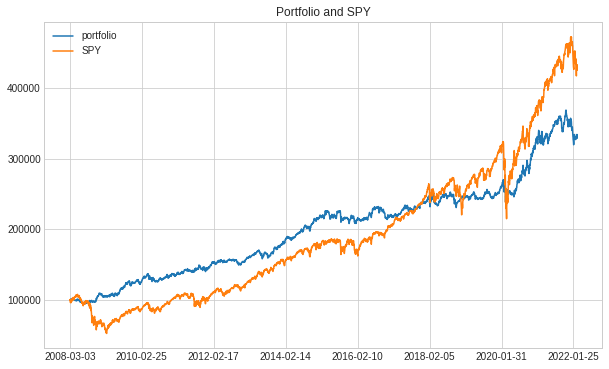

In [422]:
plot_df.plot(grid=True, title='Portfolio and SPY', figsize=(10,6))

trading_days = 252

spy_return = return_df(spy_df)
port_return = return_df(portfolio_df)
spy_volatility = round(spy_return.values.std() * sqrt(trading_days) * 100, 2)
port_volatility = round(port_return.values.std() * sqrt(trading_days) * 100, 2)

vol_df = pd.DataFrame([port_volatility, spy_volatility])
vol_df.columns = ['Yearly Standard Deviation (percent)']
vol_df.index = ['Portfolio', 'SPY']

The volatility (risk) of the ETF selection portfolio is significantly less than the
SPY ETF which tracks the S&P 500.

In [423]:
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))


def excess_return_series(asset_return: pd.Series, risk_free: pd.Series) -> pd.DataFrame:
    excess_ret = asset_return.values.flatten() - risk_free.values.flatten()
    excess_ret_df = pd.DataFrame(excess_ret, index=asset_return.index)
    return excess_ret_df


def excess_return_df(asset_return: pd.DataFrame, risk_free: pd.Series) -> pd.DataFrame:
    excess_df: pd.DataFrame = pd.DataFrame()
    for col in asset_return.columns:
        e_df = excess_return_series(asset_return[col], risk_free)
        e_df.columns = [col]
        excess_df[col] = e_df
    return excess_df

def calc_sharpe_ratio(asset_return: pd.DataFrame, risk_free: pd.Series, period: int) -> pd.DataFrame:
    excess_return = excess_return_df(asset_return, risk_free)
    return_mean: List = []
    return_stddev: List = []
    for col in excess_return.columns:
        mu = np.mean(excess_return[col])
        std = np.std(excess_return[col])
        return_mean.append(mu)
        return_stddev.append(std)
    # daily Sharpe ratio
    # https://quant.stackexchange.com/questions/2260/how-to-annualize-sharpe-ratio
    sharpe_ratio = (np.asarray(return_mean) / np.asarray(return_stddev)) * np.sqrt(period)
    result_df: pd.DataFrame = pd.DataFrame(sharpe_ratio).transpose()
    result_df.columns = asset_return.columns
    ix = asset_return.index
    dateformat = '%Y-%m-%d'
    ix_start = ix[0]
    if type(ix_start) != str:
        ix_start = datetime.strptime(ix_start, dateformat).date()
    ix_end = ix[len(ix)-1]
    if type(ix_end) != str:
         ix_end = datetime.strptime(ix_end, dateformat).date()
    index_str = f'{ix_start} : {ix_end}'
    result_df.index = [ index_str ]
    return result_df


# Interest rates are quoted for the days when banks are open. The number of bank open days is less than
# the number of trading days. Adjust the portfolio_return series and the interest rate series so that they
# align.
rf_daily_adj, portfolio_return_adj = adjust_time_series(rf_daily_df, port_return)
spy_return_adj, t = adjust_time_series(spy_return, rf_daily_adj)

rf_daily_s = rf_daily_adj.squeeze()

portfolio_sharpe = calc_sharpe_ratio(portfolio_return_adj, rf_daily_s, trading_days)
spy_sharpe = calc_sharpe_ratio(spy_return_adj, rf_daily_s, trading_days)

sharpe_df = pd.concat([portfolio_sharpe, spy_sharpe], axis=1)

╒═══════════╤═══════════════════════════════════════╕
│           │   Yearly Standard Deviation (percent) │
╞═══════════╪═══════════════════════════════════════╡
│ Portfolio │                                 10.04 │
├───────────┼───────────────────────────────────────┤
│ SPY       │                                 20.48 │
╘═══════════╧═══════════════════════════════════════╛


<h3>
Sharpe Ratio
</h3>

<p>
The yearly Sharpe ratio for the ETF rotation portfolio and SPY is shown below.
</p>

In [424]:
print(tabulate(sharpe_df, headers=[*sharpe_df.columns], tablefmt='fancy_grid'))

╒═════════════════════════╤═════════════╤══════════╕
│                         │   portfolio │      SPY │
╞═════════════════════════╪═════════════╪══════════╡
│ 2008-03-04 : 2022-03-02 │    0.864938 │ 0.596422 │
╘═════════════════════════╧═════════════╧══════════╛


<h3>
Portfolio Return
</h3>

In [425]:
def period_return(portfolio_df: pd.DataFrame, period: int) -> pd.DataFrame:
    date_index = portfolio_df.index
    values_a = portfolio_df.values
    date_list = list()
    return_list = list()
    for i in range(period, len(values_a), period):
        r = (values_a[i]/values_a[i-period]) - 1
        d = date_index[i]
        return_list.append(r)
        date_list.append(d)
    return_df = pd.DataFrame(return_list)
    return_df.index = date_list
    return return_df


period_return_df = period_return(portfolio_df=portfolio_df, period=trading_days)
spy_period_return_df = period_return(portfolio_df=spy_df, period=trading_days)
portfolio_spy_return_df = pd.concat([period_return_df, spy_period_return_df], axis=1)
portfolio_spy_return_df.columns = ['ETF Rotation', 'SPY']
portfolio_spy_return_df = round(portfolio_spy_return_df * 100, 2)

<h3>
Percentage return for the ETF Rotation Portfolio and SPY
</h3>

In [426]:
print(tabulate(portfolio_spy_return_df, headers=[*portfolio_spy_return_df.columns], tablefmt='fancy_grid'))

average_return_df = pd.DataFrame(portfolio_spy_return_df.mean()).transpose()

╒════════════╤════════════════╤════════╕
│            │   ETF Rotation │    SPY │
╞════════════╪════════════════╪════════╡
│ 2009-03-03 │           4.9  │ -46.25 │
├────────────┼────────────────┼────────┤
│ 2010-03-03 │          22.73 │  63.98 │
├────────────┼────────────────┼────────┤
│ 2011-03-02 │           6.73 │  19.13 │
├────────────┼────────────────┼────────┤
│ 2012-03-01 │          10.45 │   7.17 │
├────────────┼────────────────┼────────┤
│ 2013-03-05 │           6.82 │  14.51 │
├────────────┼────────────────┼────────┤
│ 2014-03-05 │          17.07 │  24.14 │
├────────────┼────────────────┼────────┤
│ 2015-03-05 │          15.16 │  14.29 │
├────────────┼────────────────┼────────┤
│ 2016-03-04 │          -2.77 │  -2.8  │
├────────────┼────────────────┼────────┤
│ 2017-03-06 │           2.88 │  21.15 │
├────────────┼────────────────┼────────┤
│ 2018-03-06 │          11.8  │  17.03 │
├────────────┼────────────────┼────────┤
│ 2019-03-07 │          -1.27 │   2.69 │
├────────────┼──

<h3>
Average Return (percent)
</h3>

In [427]:
print(tabulate(average_return_df, headers=[*average_return_df.columns], tablefmt='fancy_grid'))

╒════╤════════════════╤═════════╕
│    │   ETF Rotation │     SPY │
╞════╪════════════════╪═════════╡
│  0 │        9.76769 │ 13.5362 │
╘════╧════════════════╧═════════╛


<h3>
Rebalancing
</h3>

<p>
This portfolio starts out with 60% of the portfolio in equity ETFs or the cash ETF and
40% in one or more bond ETFs.  If the portfolio were not rebalanced, over time
the portion of the portfolio allocated to equity ETFs (and cash) would drift upward,
since equities usually grow faster than bonds.
</p>
<p>
By default, the portfolio is rebalanced monthly as each ETF is chosen.
In the <i><a href="https://github.com/IanLKaplan/all_weather_portfolio">All Weather Portfolio</a></i>
rebalancing the portfolio every year results in better portfolio results compared
to rebalancing monthly or quarterly.
</p>
<p>
In the case of the <i>12% Solution</i> portfolio, rebalancing yearly only resulted
in a small improvement in portfolio results (e.g., 9.8% average return vs. 9.7%
average return).
</p>
<p>
If an ETF is selected for two or more months, there is no need to rebalance
and that portion of the portfolio can be left without change.
</p>

In [428]:
portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_df, spy_df)


<h3>
Adding in Bond Rotation
</h3>

<p>
In the back-test so far the bond portion of the portfolio is always TLT (as is the
case in the first part of <i>The 12% Solution</i>).  In this section bond rotation
is added to choose between TLT and JNK (again, following <i>The 12% Solution</i>).
</p>
<p>
The plot below shows the performance of the ETF rotation portfolio, with bond rotation
(TLT and JNK).
</p>

<AxesSubplot:title={'center':'Portfolio with bond rotation and SPY'}>

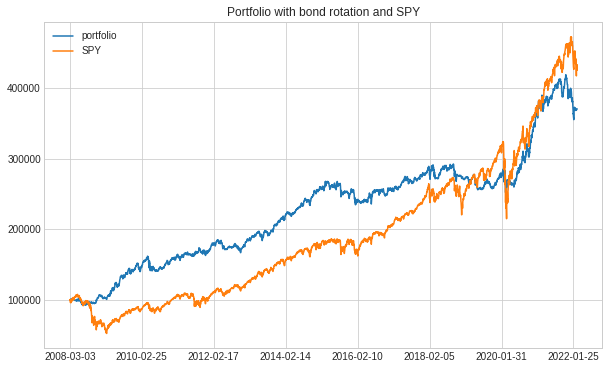

In [429]:
plot_df.plot(grid=True, title='Portfolio with bond rotation and SPY', figsize=(10,6))

<h3>
Standard Deviation and Sharpe Ratio
</h3>

<p>
The addition of bond ETF rotatoin slightly increased the standard deviation, which
resulted in a slight decrease in the Sharpe ratio.
</p>

In [430]:
port_return = return_df(portfolio_df)
port_volatility = round(port_return.values.std() * sqrt(trading_days) * 100, 2)

vol_df = pd.DataFrame([port_volatility, spy_volatility])
vol_df.columns = ['Yearly Standard Deviation (percent)']
vol_df.index = ['Portfolio', 'SPY']

print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

rf_daily_adj, portfolio_return_adj = adjust_time_series(rf_daily_df, port_return)
portfolio_sharpe = calc_sharpe_ratio(portfolio_return_adj, rf_daily_s, trading_days)
sharpe_df = pd.concat([portfolio_sharpe, spy_sharpe], axis=1)
print("Sharpe Ratio:")
print(tabulate(sharpe_df, headers=[*sharpe_df.columns], tablefmt='fancy_grid'))

╒═══════════╤═══════════════════════════════════════╕
│           │   Yearly Standard Deviation (percent) │
╞═══════════╪═══════════════════════════════════════╡
│ Portfolio │                                 11.26 │
├───────────┼───────────────────────────────────────┤
│ SPY       │                                 20.48 │
╘═══════════╧═══════════════════════════════════════╛
Sharpe Ratio:
╒═════════════════════════╤═════════════╤══════════╕
│                         │   portfolio │      SPY │
╞═════════════════════════╪═════════════╪══════════╡
│ 2008-03-04 : 2022-03-02 │    0.856784 │ 0.596422 │
╘═════════════════════════╧═════════════╧══════════╛


<p>
Adding ETF rotation to the bond portion of the portfolio results in performance that is
close to the S&P 500 with half the volatility (risk).
</p>
<p>
The table below shows the yearly percentage returns for the portfolio without bond
ETF rotation, the portfolio with bond ETF rotation and SPY (S&P 500).
</p>

In [431]:
period_return_bond_df = period_return(portfolio_df=portfolio_df, period=trading_days)
portfolio_spy_return_df = pd.concat([period_return_df, period_return_bond_df, spy_period_return_df], axis=1)
portfolio_spy_return_df.columns = ['ETF Rotation','ETF Rotation (bond)', 'SPY']
portfolio_spy_return_df = round(portfolio_spy_return_df * 100, 2)

print(tabulate(portfolio_spy_return_df, headers=[*portfolio_spy_return_df.columns], tablefmt='fancy_grid'))

average_return_df = pd.DataFrame(portfolio_spy_return_df.mean()).transpose()

╒════════════╤════════════════╤═══════════════════════╤════════╕
│            │   ETF Rotation │   ETF Rotation (bond) │    SPY │
╞════════════╪════════════════╪═══════════════════════╪════════╡
│ 2009-03-03 │           4.9  │                  2.68 │ -46.25 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2010-03-03 │          22.73 │                 45.72 │  63.98 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2011-03-02 │           6.73 │                  8.05 │  19.13 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2012-03-01 │          10.45 │                 11.02 │   7.17 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2013-03-05 │           6.82 │                  4.31 │  14.51 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2014-03-05 │          17.07 │                 20.05 │  24.14 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2015-03-05 │          1

<h3>
Average Return (percent) ETF Rotation, including bond rotation
</h3>
<p>
The book <i>The 12% Solution</i> is named for the 12% average yearly return from the
ETF rotation portfolio that includes bond rotation.  The book did not include recent
market period that has been affected by market volatility from COVID and the Russian
attack on the Ukraine.
</p>

In [432]:
print(tabulate(average_return_df, headers=[*average_return_df.columns], tablefmt='fancy_grid'))

╒════╤════════════════╤═══════════════════════╤═════════╕
│    │   ETF Rotation │   ETF Rotation (bond) │     SPY │
╞════╪════════════════╪═══════════════════════╪═════════╡
│  0 │        9.76769 │                  11.5 │ 13.5362 │
╘════╧════════════════╧═══════════════════════╧═════════╛



<h3>
Notebook results and <i>12% Solution Results</i>
</h3>
<p>
Although the overall portfolio return is close to the return reported in <i>The 12%
Solution</i>, I have been unable to exactly reproduce the results reported in the book
and on the trendlineprofits.com web site. The difference in results may be
due to different asset selection.
</p>
<p>
For example, the portfolio asset selected in May of 2008 by the notebook code is QQQ.
This asset is selected by choosing the asset with the highest return in the set
IWM, MDY, QQQ, SPY and SHY.  The asset shown on the trendlineprofits.com web site
for May of 2008 is MDY. The notebook lookback period used by the notebook is
Feb 1, 2008 to May 2, 2008 (2008-02-01 to 2008-05-02).
</p>
<p>
Looking at this period using stockcharts.com it looks like QQQ is the right choice for this
period, so it is not clear that there is an error in the notebook code.
</p>
<p>
The results over the full 14-year time period appear to be close to those reported on
trendlineprofits.com.  The results for three and five year past periods differ
fairly dramaticly from those reported on trendlineprofits.com.  The trendlineprofits.com
show a portfolio that closely follows SPY.  This is not the case for the portfolios
calculated in the notebook.
</p>

In [433]:
five_year_start = datetime.fromisoformat('2017-01-03')
three_year_start = datetime.fromisoformat('2019-01-02')
# end_date is today minus one day

five_year_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=five_year_start,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, five_year_portfolio_df, spy_df)

<h4>
Past Five Years
</h4>

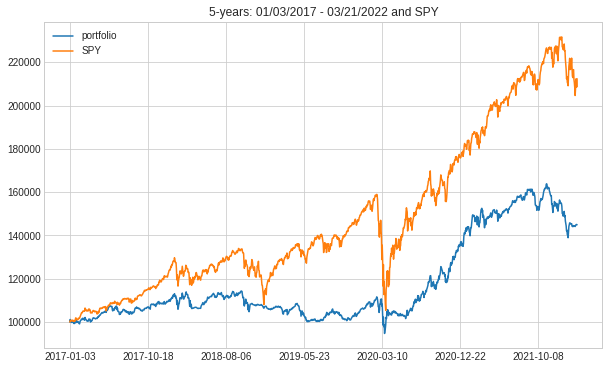

In [434]:
plot_df.plot(grid=True, title=f'5-years: {five_year_start.strftime("%m/%d/%Y")} - {end_date.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))

three_year_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=three_year_start,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, three_year_portfolio_df, spy_df)

<h4>
Past Three Years
</h4>

<AxesSubplot:title={'center':'3-years: 01/02/2019 - 03/21/2022 and SPY'}>

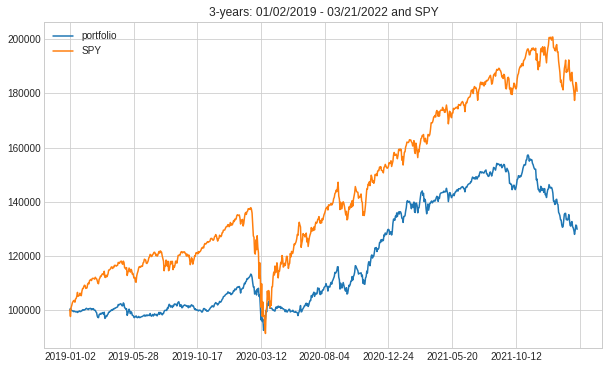

In [435]:
plot_df.plot(grid=True, title=f'3-years: {three_year_start.strftime("%m/%d/%Y")} - {end_date.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))

<h2>
Difference Between Notebook and trendlineprofits.com
</h2>
<h3>
Performance for 2019
</h3>

<p>
In this section I try to track down the difference between the results published
on trendlineprofits.com and this notebook.  This section looks at the results for
one year, 2019.
</p>
<p>
The plot below shows the results for the ETF rotation portfolio (with bond rotation)
for 2019.
</p>

<AxesSubplot:title={'center':'SPY Only (return calc)'}, xlabel='Date'>

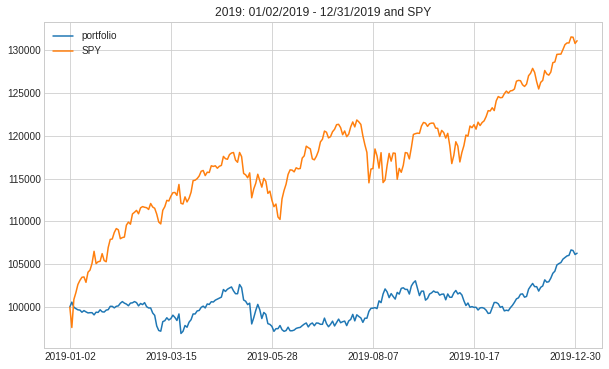

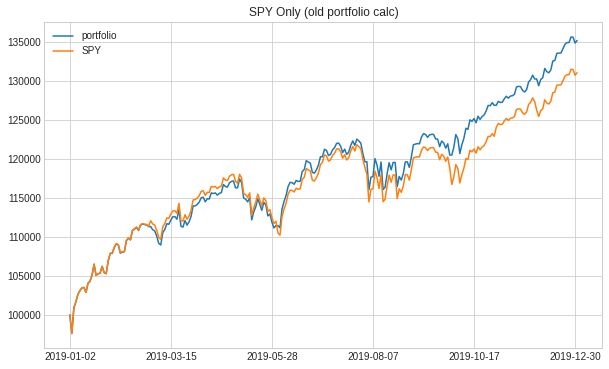

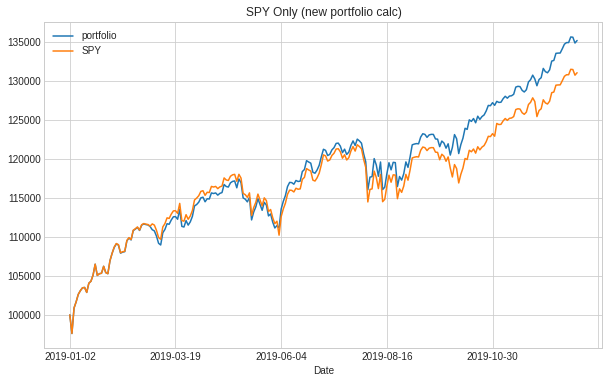

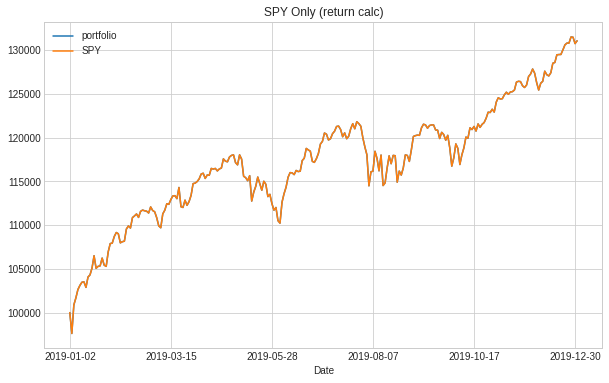

In [436]:
d2019_portfolio_df, d2019_assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=d2019_start,
                                              end_date=d2019_end)

plot_df = build_plot_data(holdings, d2019_portfolio_df, spy_df)
plot_df.plot(grid=True, title=f'2019: {d2019_start.strftime("%m/%d/%Y")} - {d2019_end.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))

spy_unadj = pd.DataFrame(asset_adj_close['SPY'])

spyonly_df, t = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=spy_unadj,
                                              bond_etfs=spy_unadj,
                                              start_date=d2019_start,
                                              end_date=d2019_end)

plot_df = build_plot_data(holdings, spyonly_df, spy_unadj)
plot_df.plot(grid=True, title='SPY Only (old portfolio calc)', figsize=(10,6))

def calc_portfolio_returns(asset_etfs: pd.DataFrame,
                           bond_etfs: pd.DataFrame,
                           start_date: datetime,
                           end_date: datetime) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """

    :param asset_etfs:
    :param bond_etfs:
    :param start_date:
    :param end_date:
    :return: a return series for the equity (or SPY) assets and the bond assets and a DataFrame with the chosen
             ETFs.
    """
    asset_return_df = pd.DataFrame()
    bond_return_df = pd.DataFrame()
    back_delta = relativedelta(months=3)
    forward_delta = relativedelta(months=1)
    date_index = asset_etfs.index
    start_date_i = start_date
    current_year = start_date.year
    portfolio_a = np.zeros(0)
    last_index = 0
    bond_asset_l = list()
    equity_asset_l = list()
    month_index_l = list()
    date_index_l = list()
    while start_date_i <= end_date:
        # Start of the back-test data
        back_start = start_date_i - back_delta
        # End of the backtest data
        back_end = start_date_i
        # end of the forward data period (e.g., one month)
        forward_end = start_date_i + forward_delta
        start_ix = findDateIndex(date_index, back_start)
        end_ix = findDateIndex(date_index, back_end)
        forward_ix = findDateIndex(date_index, forward_end)
        if start_ix >= 0 and end_ix >= 0 and forward_ix >= 0:
            # Choose an asset based on the past three months
            asset_df = chooseAsset(start=start_ix, end=end_ix, asset_set=asset_etfs)
            asset_month_df = asset_df[:][end_ix:forward_ix]
            bond_df = chooseAsset(start=start_ix, end=end_ix, asset_set=bond_etfs)
            bond_month_df = bond_df[:][end_ix:forward_ix]
            bond_asset = bond_df.columns[0]
            equity_asset = asset_df.columns[0]
            equity_asset_l.append(equity_asset)
            bond_asset_l.append(bond_asset)
            month_index = asset_month_df.index
            month = month_index[0]
            print(f'month {month_index[0]} - {month_index[-1]}')
            month_index_l.append(month)
            date_index_l.extend(month_index)
            asset_return_month_df = return_df(asset_month_df)
            bond_return_month_df = return_df(bond_month_df)
            asset_return_month_df.columns = ['returns']
            bond_return_month_df.columns = ['returns']
            asset_return_df = pd.concat([asset_return_df, asset_return_month_df], axis=0)
            bond_return_df = pd.concat([bond_return_df, bond_return_month_df], axis=0)
            start_date_i = forward_end
        else:
            break
    choices_df = pd.DataFrame()
    choices_df['Equity'] = pd.DataFrame(equity_asset_l)
    choices_df['Bond'] = pd.DataFrame(bond_asset_l)
    choices_df.index = month_index_l
    return asset_return_df, bond_return_df, choices_df


def apply_portfolio_returns(holdings: float,
                            equity_percent: float,
                            bond_percent: float,
                            first_day: str,
                            asset_return_df: pd.DataFrame,
                            bond_return_df: pd.DataFrame) -> pd.DataFrame:
    assert asset_return_df.shape[0] == bond_return_df.shape[0]
    # The code assumes that the indexes are the same, so test that this assumption is true
    assert all(asset_return_df.index == bond_return_df.index)

    equity_holding = holdings * equity_percent
    bond_holding = holdings * bond_percent
    portfolio_a = np.zeros( asset_return_df.shape[0] + 1 )
    portfolio_a[0] = equity_holding + bond_holding
    date_index = asset_return_df.index
    asset_return_a = asset_return_df.values
    bond_return_a = bond_return_df.values
    start_date = date_index[0]
    if type(start_date) == str:
        start_date = datetime.fromisoformat(start_date)
    month = start_date.month
    ix = 0
    portfolio_total = portfolio_a[0]
    for ix_date in date_index:
        if type(ix_date) == str:
            ix_date = datetime.fromisoformat(ix_date)
        current_month = ix_date.month
        if month != current_month:
            # rebalance the portfolio every month
            equity_holding = portfolio_total * equity_percent
            bond_holding = portfolio_total * bond_percent
            month = current_month
        equity_holding = equity_holding + equity_holding * asset_return_a[ix]
        bond_holding = bond_holding + bond_holding * bond_return_a[ix]
        portfolio_total = equity_holding + bond_holding
        portfolio_a[ix+1] = portfolio_total
        ix = ix + 1
    date_index = date_index.insert(0, first_day)
    portfolio_df = pd.DataFrame(portfolio_a)
    portfolio_df.index = date_index
    portfolio_df.columns = ['portfolio']
    return portfolio_df



def portfolio_return_new(holdings: float,
                         asset_percent: float,
                         bond_percent: float,
                         asset_etfs: pd.DataFrame,
                         bond_etfs: pd.DataFrame,
                         start_date: datetime,
                         end_date: datetime) -> Tuple[pd.DataFrame, pd.DataFrame]:
    asset_return_df, bond_return_df, assets_df = calc_portfolio_returns(asset_etfs=asset_etfs,
                                                                        bond_etfs=bond_etfs,
                                                                        start_date=start_date,
                                                                        end_date=end_date)
    start_ix = findDateIndex(asset_etfs.index, start_date)
    first_date = asset_adj_close.index[start_ix]
    port_df = apply_portfolio_returns(holdings=holdings,
                                      equity_percent=asset_percent,
                                      bond_percent=bond_percent,
                                      first_day=first_date,
                                      asset_return_df=asset_return_df,
                                      bond_return_df=bond_return_df)
    return port_df, assets_df


spyonly_new_df, t = portfolio_return_new(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=spy_unadj,
                                              bond_etfs=spy_unadj,
                                              start_date=d2019_start,
                                              end_date=d2019_end)

plot_df = build_plot_data(holdings, spyonly_new_df, spy_unadj)
plot_df.plot(grid=True, title='SPY Only (new portfolio calc)', figsize=(10,6))

spy_unadj = pd.DataFrame(asset_adj_close['SPY'])
start_ix = findDateIndex(spy_unadj.index, d2019_start)
end_ix = findDateIndex(spy_unadj.index, d2019_end)
start_val = spy_unadj[spy_unadj.columns[0]].values[start_ix]
spy_section = pd.DataFrame(spy_unadj[spy_unadj.columns[0]][start_ix:end_ix+1])
spy_asset_return = return_df(spy_section)
spy_bond_return = return_df(spy_section)

first_date = asset_adj_close.index[start_ix]
port_df = apply_portfolio_returns(holdings=holdings,
                                      equity_percent=equity_percent,
                                      bond_percent=bond_percent,
                                      first_day=first_date,
                                      asset_return_df=spy_asset_return,
                                      bond_return_df=spy_bond_return)

plot_df = build_plot_data(holdings, port_df, spy_unadj)
plot_df.plot(grid=True, title='SPY Only (return calc)', figsize=(10,6))

<h4>
2019 Assets
</h4>

<p>
One difference between the notebook results and the trendlineprofits.com results
are the ETF assets that are selected.
</p>
<p>
To briefly review the ETF rotation algorithm:
</p>
<ol>
<li>
An ETF is selected for the current month.  This is done by looking back over the past
three months and selecting the ETF with the highest return.
</li>
<li>
The return for the ETF becomes the return for the ETF section of the portfolio.
</li>
</ol>
<p>
The plots below show percentage returns for the lookback period.  The ETF that is
selected by the notebook code is listed in the plot title.  This is the ETF that
is used for the "current" month which starts at the end of the look back period.
</p>
<p>
The ETF that is selected listed on the Trendline web site for the period is
shown in the title. Only the plots where the Trendline and notebook selectoin differ
are shown.
</p>

In [437]:
trendline_assets = ['SHY', # 1
                    'QQQ', # 2
                    'QQQ', # 3
                    'QQQ', # 4
                    'QQQ', # 5
                    'QQQ', # 6
                    'SHY', # 7
                    'SPY', # 8
                    'QQQ', # 9
                    'SPY', # 10
                    'QQQ', # 11
                    'QQQ' # 12
                    ]

trendline_df = pd.DataFrame(trendline_assets)
trendline_df.index = d2019_assets_df.index
d2019_assets_df['trendline'] = trendline_df
d2019_assets_df.drop(d2019_assets_df.columns[1], inplace=True, axis=1)
print(tabulate(d2019_assets_df, headers=['Equity ETFs', 'Trendline ETFs'], tablefmt='fancy_grid'))


def display_asset_selection(month_start: str, prices_df: pd.DataFrame) -> None:
    look_back_end = datetime.fromisoformat(month_start)
    look_back_start = look_back_end - relativedelta(months=3)
    date_index = prices_df.index
    start_ix = findDateIndex(date_index, look_back_start)
    end_ix = findDateIndex(date_index, look_back_end)
    t = chooseAsset(start_ix, end_ix, prices_df)
    name = t.columns[0]
    period_return_df = percent_return_df(start_date=look_back_start,
                                         end_date=look_back_end,
                                         prices_df=prices_df)
    title_str =f'{look_back_start.strftime("%m/%d/%Y")} - {look_back_end.strftime("%m/%d/%Y")} asset {name}'
    ax = period_return_df.plot(grid=True, title=title_str, figsize=(10,6))
    ax.set_ylabel('Return Percent')


╒════════════╤═══════════════╤══════════════════╕
│            │ Equity ETFs   │ Trendline ETFs   │
╞════════════╪═══════════════╪══════════════════╡
│ 2019-01-02 │ SHY           │ SHY              │
├────────────┼───────────────┼──────────────────┤
│ 2019-02-01 │ SHY           │ QQQ              │
├────────────┼───────────────┼──────────────────┤
│ 2019-03-01 │ IWM           │ QQQ              │
├────────────┼───────────────┼──────────────────┤
│ 2019-04-02 │ QQQ           │ QQQ              │
├────────────┼───────────────┼──────────────────┤
│ 2019-05-02 │ QQQ           │ QQQ              │
├────────────┼───────────────┼──────────────────┤
│ 2019-05-31 │ SHY           │ QQQ              │
├────────────┼───────────────┼──────────────────┤
│ 2019-07-02 │ QQQ           │ SHY              │
├────────────┼───────────────┼──────────────────┤
│ 2019-08-02 │ SHY           │ SPY              │
├────────────┼───────────────┼──────────────────┤
│ 2019-08-30 │ QQQ           │ QQQ              │


<h4>
Trendline selects QQQ
</h4>

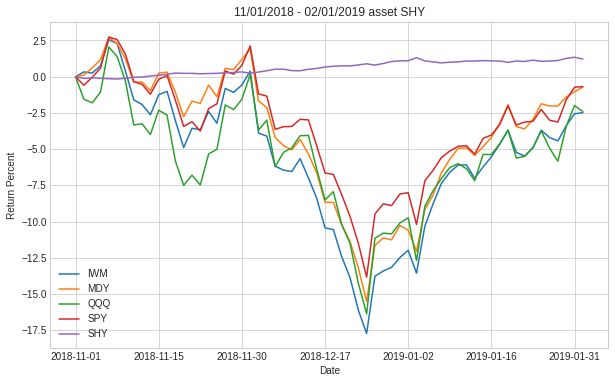

In [438]:
display_asset_selection('2019-02-01', asset_adj_close)

<h4>
Trendline selects QQQ
</h4>

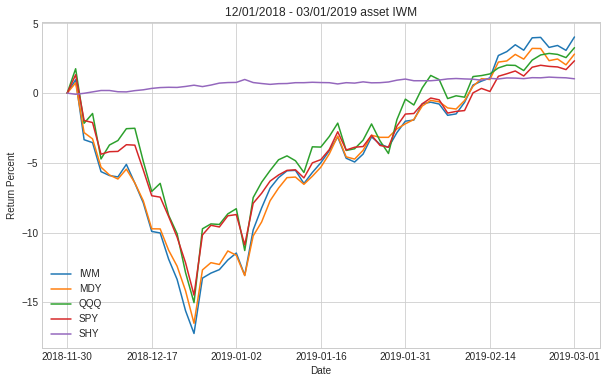

In [439]:
display_asset_selection('2019-03-01', asset_adj_close)


<h4>
Trendline selects QQQ
</h4>

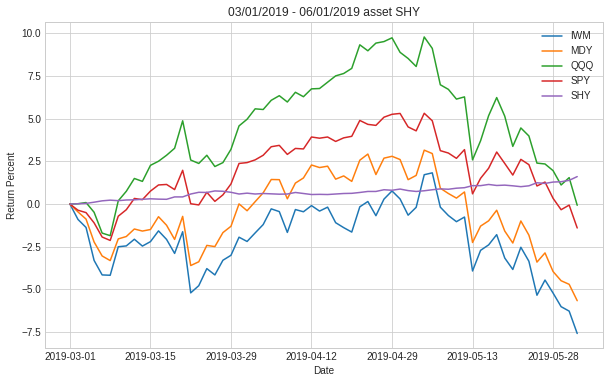

In [440]:
display_asset_selection('2019-06-01', asset_adj_close)

<h4>
Trendline selects SHY
</h4>

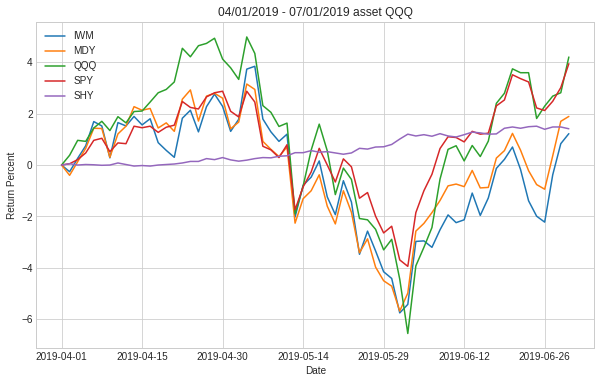

In [441]:
display_asset_selection('2019-07-01', asset_adj_close)

<h4>
Trendline selects SHY
</h4>

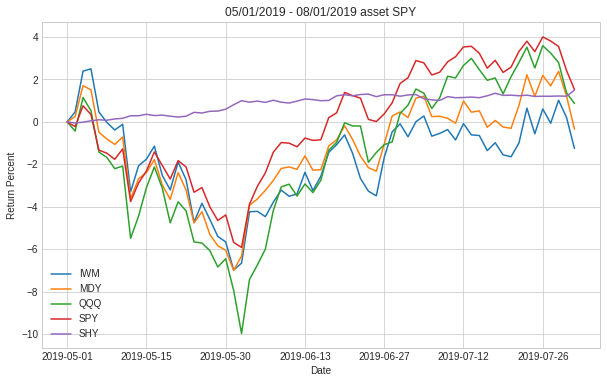

In [442]:
display_asset_selection('2019-08-01', asset_adj_close)



<h4>
Trendline selects SPY
</h4>

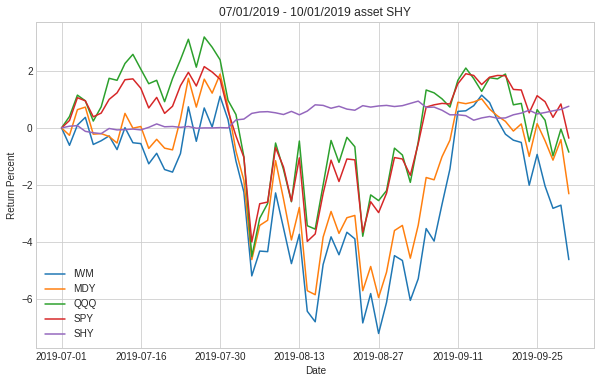

In [443]:
display_asset_selection('2019-10-01', asset_adj_close)

<p>
The plots show that if the backward looking period differs by a few days, a different
ETF would be selected. The differences between the notebook results and the
Trendline results could be a result of slightly different periods.
</p>
<p>
Short term market prices contain significant noise (returns that are normally distributed).
This is reflected in the ETF selection.
</p>

<h3>
Adding SHY as a Bond Option
</h3>

<p>
In the question and answer section of the <i>12% Solution</i> the author is asked whether
adding SHY (the cash proxy ETF) might produce better results. He writes that in the back
tests adding SHY did not improve the results. However, the books results end around 2018,
before COVID and the Russian invasion of the Ukraine.  This section looks at whether
in this later period adding SHY to the bond set might produce better results.
</p>

In [444]:
fixed_income_plus_shy = pd.concat([fixed_income_adjclose, shy_adj_close], axis=1)
portfolio_bond_plus_shy_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_plus_shy,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_bond_plus_shy_df, spy_df)

<p>
As reported in <i>The 12% Solution</i> including SHY in the bond set results in
slightly worse portfolio performance.
</p>

<AxesSubplot:title={'center':'Portfolio (bond + SHY) and SPY'}>

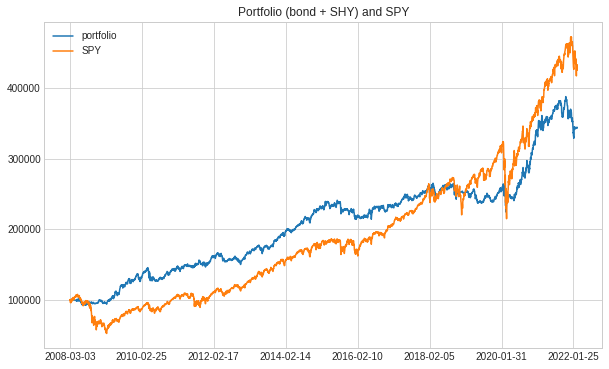

In [445]:
plot_df.plot(grid=True, title='Portfolio (bond + SHY) and SPY', figsize=(10,6))

<h3>
Results with SPY and Bond ETF Rotation
</h3>

<p>
The equity ETFs that are used in the ETF rotation are all highly correlated (correlations
close to 1.0).  This section shows the performance of an ETF rotation that consists of
SPY (the S&P 500 ETF) and SHY (the cash ETF), with bond rotation between TLT and JNK.
</p>

<AxesSubplot:title={'center':'SPY/SHY Portfolio and SPY'}>

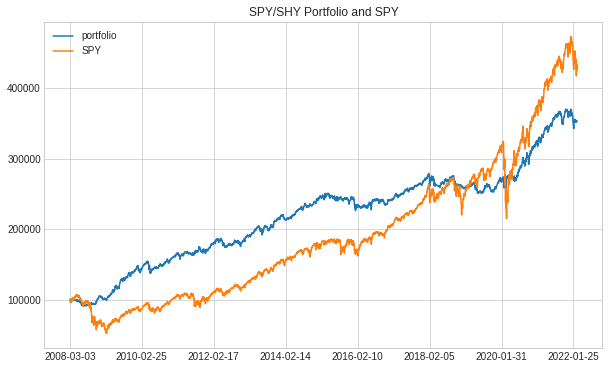

In [446]:
limited_asset_set_df = asset_adj_close[['SPY', 'SHY']]

portfolio_limited_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=limited_asset_set_df,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_limited_df, spy_df)

plot_df.plot(grid=True, title='SPY/SHY Portfolio and SPY', figsize=(10,6))

<p>
The above plot shows that an equity portfolio that is just composed of only the SPY
and SHY ETFs has worse performance after 2018 than the complete ETF rotation set.  Although
the ETFs in the rotation set are highly correlated, there are periodic differences
in performance which may explain this result.
</p>

<h2>
Expanding the ETF Universe
</h2>

<p>
<i>The 12% Solution</i> is designed so that anyone who is willing
to spend a little bit of time every month can implement the investment strategy.
For readers who subscribe to the author's free email newletter it is even simpler:
the current <i>12% solution</i> stock and bond recommendations are included.
</p>
<p>
This section of the notebook investigates the ETF rotation results with an expanded
ETF universe.  Some of these assets are also in the <i>12% Solution</i> asset set.
</p>
<p>
The ETF universe is limited by the backtest start date of March 3, 2008 (2008-03-03).
The ETF inception date needs to be at least three trading months before this date
to provide sufficient history to select an ETF on the start date.
</p>

<h3>
Bond ETFs
</h3>

<ul>
<li>
<p>
<b>SPIP - SPDR Portfolio TIPS ETF</b>
</p>
<p>
Inception Date: 05/25/2007
</p>
</li>

<li>
<p>
BIV - Vanguard Intermediate-Term Bond ETF
</p>
<p>
Inception Date: 04/03/2007
</p>
</li>

<li>
<p>
IEF - iShares 7-10 Year Treasury Bond ETF
</p>
<p>
Inception Date: 07/22/2002
</p>
</li>

<li>
<p>
TLT - iShares 20+ Year Treasury Bond ETF (from <i>12% Solution</i>)
</p>
<p>
Inception Date: 07/22/2002
</p>
</li>

<li>
<p>
VYM - Vanguard High Dividend Yield ETF (replacement for JNK)
</p>
<p>
Inception Date: 11/10/2006
</p>
</li>

</ul>

<h3>
Equity ETFs
</h3>

<ul>
<li>
<p>
XLE - Energy Select Sector SPDR Fund
</p>
<p>
Inception Date: 12/16/1998
</p>
</li>

<li>
<p>
VUG - Vanguard Growth ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VBR - Vanguard Small-Cap Value ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
FXZ - First Trust Materials AlphaDEX Fund
</p>
<p>
Inception Date: 05/08/2007
</p>
</li>

<li>
<p>
VDC - Vanguard Consumer Staples ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
MDY - SPDR S&P Midcap 400 ETF Trust
</p>
<p>
Inception Date: 05/04/1995
</p>
</li>

<li>
<p>
QQQ - Invesco QQQ Trust
</p>
<p>
Inception Date: 03/10/1999
</p>
</li>

<li>
<p>
VCR - Vanguard Consumer Discretionary ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VFH - Vanguard Financials ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VGT - Vanguard Information Technology ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VHT - Vanguard Health Care ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
IWM - iShares Russell 2000 ETF
</p>
<p>
Inception Date: 05/22/2000
</p>
</li>

<li>
<p>
SPY - SPDR S&P 500 ETF Trust
</p>
<p>
Inception Date: 01/22/1993
</p>
</li>

<li>
<p>
SOXX - iShares Semiconductor ETF
</p>
<p>
Inception Date: 07/10/2001
</p>
</li>

</ul>

<h3>
Short Funds
</h3>

<p>
These ETFs take short positions against market indexes. They can be much more
volatile and, at least in the long term, risky than a standard long ETF.
</p>
<p>
The ETF rotation algorithm moves in and out of ETFs, so they are not held for a long
period of time, so the risk may be less.
</p>

<ul>

<li>
<p>
SDS - ProShares UltraShort S&P500
</p>
<p>
Inception Date: 07/11/2006
</p>
</li>

<li>
<p>
RWM - ProShares Short Russell 2000
</p>
<p>
Inception Date: 01/23/2007
</p>
</li>

</ul>

<p>
Data has already been downloaded for IWM, MDY, QQQ, SPY and TLT.
</p>

In [447]:
new_equity_etfs = ['XLE', 'VUG', 'VBR', 'FXZ',
                   'VDC', 'VCR', 'VFH', 'VGT',
                   'VHT', 'SOXX']

new_bond_etfs = ['SPIP', 'BIV', 'IEF', 'VYM']

short_etfs = ['SDS', 'RWM']

new_etf_adjclose_file = 'new_equity_etf_adjclose'
new_equity_adj_close = get_market_data(file_name=new_etf_adjclose_file,
                                data_col='Adj Close',
                                symbols=new_equity_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

new_bond_adjclose_file = 'new_bond_etf_adjclose'
new_bond_adj_close = get_market_data(file_name=new_bond_adjclose_file,
                                data_col='Adj Close',
                                symbols=new_bond_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

short_etf_adjclose_file = 'short_etf_adjclose'
short_etf_adj_close = get_market_data(file_name=short_etf_adjclose_file,
                                data_col='Adj Close',
                                symbols=short_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

new_etf_set = pd.concat([new_equity_adj_close, equity_adj_close, shy_adj_close], axis=1)
new_bond_set = pd.concat([new_bond_adj_close, fixed_income_adjclose['TLT']], axis=1)

portfolio_new_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=new_etf_set,
                                              bond_etfs=new_bond_set,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_new_df, spy_df)

<h3>
ETF Rotation with an Expanded ETF Set
</h3>

<p>
The plot below show the ETF rotation portfolio with an expanded set of ETFs.  The
results are significantly worse than the base <i>12% Solution</i> portfolio.  Not only
is the terminal value of the portfolio less than the <i>12% Solution</i> portfolio, but
it also appears to be more volatile.
</p>

<AxesSubplot:title={'center':'Expanded ETF Universe Portfolio and SPY'}>

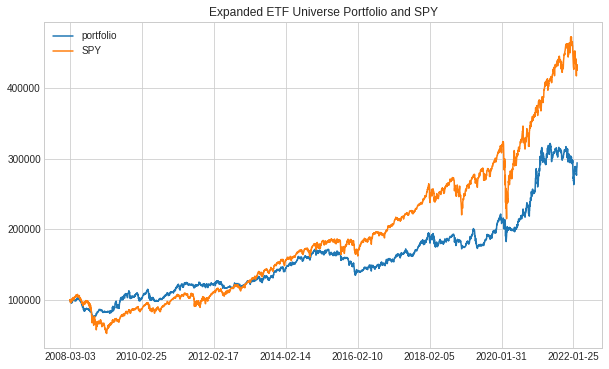

In [448]:
plot_df.plot(grid=True, title='Expanded ETF Universe Portfolio and SPY', figsize=(10,6))

<p>
The expanded ETF universe was chosen to provide broad coverage over a number of sectors.
The hope is that different sectors might have superior performance, even if this was
not the case over time. As these results demonstrate, this did not happen.
</p>
<p>
A different choice of ETFs for the expanded universe might produce better performance.
These assets should show correlation between the three month return and the return
in the next month.
</p>

<h3>
The 12% Portfolio plus Market Short ETFs
</h3>

<p>
There are a number of ETFs that take a short position with respect to market indexes.
The idea behind these is seductive: in a market down period these ETFs will provide
better results when equity long ETFs lose money.  In theory the market short ETFs
should would only benefit the portfolio since they would only be chosen when the market
as down.
</p>

In [449]:
assets_plus_short = pd.concat([asset_adj_close, short_etf_adj_close], axis=1)
portfolio_plus_short_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=assets_plus_short,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_plus_short_df, spy_df)

<p>
As the plot below shows, the ETF set that includes the market short ETFs have the worst
performance of any portfolio so far.
</p>
<p>
The ETF for the current month is chosen on the basis of the performance for the past
three months.  This is a momentum strategy and the market short ETFs seem to perform
very badly with this strategy. From these results we can assume that the next month
is not highly correlated with the return over the past three months.
</p>

<AxesSubplot:title={'center':'Portfolio plus short ETFs and SPY'}>

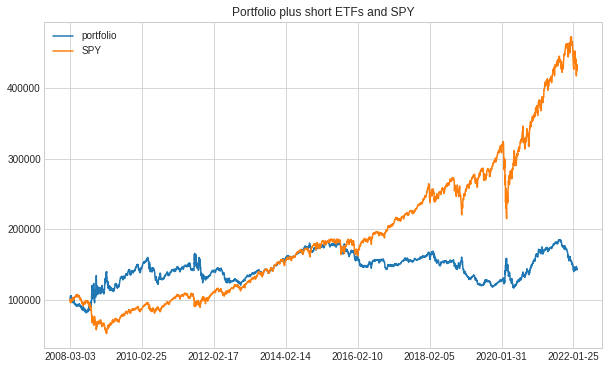

In [450]:
plot_df.plot(grid=True, title='Portfolio plus short ETFs and SPY', figsize=(10,6))

<h3>
Analyzing Momentum
</h3>
<p>
The results with the expanded ETF set and the short ETF set show much worse portfolio
performance than the results with <i>The 12% Portfolio</i>.  The results with the
short ETFs are particularly bad.
</p>
<p>
The momentum algorithm used in the ETF rotation portfolio depends on the prediction
of the next month's return based on the return over the previous three months.  If the return
in the last three months is positive, the return in the next month should be positive.
</p>
<p>
In the case of the market short ETFS, the past three month return does
not appear to strongly predict the next month return.
</p>
<p>
In this section we examine the correlation statistical test to see if correlation
can be used to successfully select and ETF set that will result in superior
portfolio performance.
</p>

In [451]:
def calculate_return_series(close_prices_df: pd.DataFrame,
                            start_date: datetime) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    :param close_prices_df: a DataFrame of close prices where all of the data aligns on date
    :param start_date: the start date to use in calculating the returns
    :return: a Series with the past three month return and the return for the next month
    """
    date_index = close_prices_df.index
    end_date = date_index[-1]
    end_date_t = end_date
    if type(end_date) == str:
        end_date_t = datetime.fromisoformat(end_date)
    back_delta = relativedelta(months=3)
    forward_delta = relativedelta(months=1)
    start_date_i = start_date
    three_month_return_df = pd.DataFrame()
    one_month_return_df = pd.DataFrame()
    while start_date_i <= end_date_t:
        # Start of the back-test data
        back_start = start_date_i - back_delta
        # End of the backtest data
        back_end = start_date_i
        # end of the forward data period (e.g., one month)
        forward_end = start_date_i + forward_delta
        start_ix = findDateIndex(date_index, back_start)
        end_ix = findDateIndex(date_index, back_end)
        forward_ix = findDateIndex(date_index, forward_end)
        if start_ix >= 0 and end_ix >= 0 and forward_ix >= 0:
            three_month_a = (close_prices_df[:][start_ix:start_ix+1].values / close_prices_df[:][end_ix:end_ix+1].values) - 1
            three_month_return_df = pd.concat([three_month_return_df, pd.DataFrame(three_month_a)])
            one_month_a = (close_prices_df[:][forward_ix:forward_ix+1].values / close_prices_df[:][end_ix:end_ix+1].values) - 1
            one_month_return_df = pd.concat([one_month_return_df, pd.DataFrame(one_month_a)])
        else:
            break
        start_date_i = forward_end
    three_month_return_df.columns = close_prices_df.columns
    one_month_return_df.columns = close_prices_df.columns
    return three_month_return_df, one_month_return_df


all_etf_adj_close = pd.concat([equity_adj_close,
                               new_equity_adj_close,
                               short_etf_adj_close,
                               shy_adj_close], axis=1)
corr_end_date = start_date + relativedelta(years=8)
date_index = all_etf_adj_close.index
corr_end_ix = findDateIndex(date_index, corr_end_date)
all_etf_adj_close_trunc = all_etf_adj_close[:][0:corr_end_ix+1]
three_month_df, one_month_df = calculate_return_series(close_prices_df=all_etf_adj_close_trunc, start_date=start_date)
return_corr = three_month_df.corrwith(one_month_df)
return_corr.sort_values(ascending=False, inplace=True)
return_corr_df = pd.DataFrame(return_corr)


<h3>
Correlation
</h3>

<p>
The table below shows the correlation between the three month return and the one
month return for the ETFs that hae been used in ETF rotations above.
</p>
<p>
A correlation of 0 mean that there is no correlation between the series.  A correlation of
1.0 means that the two time series are exactly correlated.
</p>

In [452]:
print(tabulate(return_corr_df, headers=['Correlation'], tablefmt='fancy_grid'))

╒══════╤═══════════════╕
│      │   Correlation │
╞══════╪═══════════════╡
│ VDC  │    0.129556   │
├──────┼───────────────┤
│ VBR  │    0.129464   │
├──────┼───────────────┤
│ VCR  │    0.118588   │
├──────┼───────────────┤
│ IWM  │    0.112059   │
├──────┼───────────────┤
│ RWM  │    0.106724   │
├──────┼───────────────┤
│ SDS  │    0.0840105  │
├──────┼───────────────┤
│ VHT  │    0.0768093  │
├──────┼───────────────┤
│ FXZ  │    0.0614563  │
├──────┼───────────────┤
│ MDY  │    0.0335955  │
├──────┼───────────────┤
│ SPY  │    0.0302279  │
├──────┼───────────────┤
│ VFH  │    0.0202531  │
├──────┼───────────────┤
│ XLE  │    0.015329   │
├──────┼───────────────┤
│ QQQ  │    0.00977975 │
├──────┼───────────────┤
│ VGT  │   -0.0115311  │
├──────┼───────────────┤
│ VUG  │   -0.0131131  │
├──────┼───────────────┤
│ SHY  │   -0.0263293  │
├──────┼───────────────┤
│ SOXX │   -0.0312999  │
╘══════╧═══════════════╛


<p>
Arbitrarily choosing a correlation that is greater than 0.10, an ETF rotation set
is constructed.
</p>

In [453]:
etf_corr_set = return_corr_df[:][return_corr_df >= 0.10].dropna()
high_corr_etfs = all_etf_adj_close[etf_corr_set.index]
# make sure that SHY is included in the ETF set
if not 'SHY' in high_corr_etfs.columns:
    high_corr_etfs = pd.concat([high_corr_etfs, shy_adj_close], axis=1)

high_corr_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=high_corr_etfs,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=corr_end_date,
                                              end_date=end_date)

twelve_percent_df,  assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=corr_end_date,
                                              end_date=end_date)


spy_df_adj, t = adjust_time_series(spy_df, high_corr_portfolio_df)

plot_df = build_plot_data(holdings, high_corr_portfolio_df, spy_df_adj)
plot_df['twelve percent'] = twelve_percent_df
plot_df.columns = ['Correlation', 'SPY', 'twelve percent']

The plot below shows the results of the "high correlation" portfolio, The 12% portfolio
and SPY.  The performance of the high correlation portfolio is much worse than the
other two portfolios.

<AxesSubplot:title={'center':'High Correlation ETFs, 12% Portfolio and SPY'}>

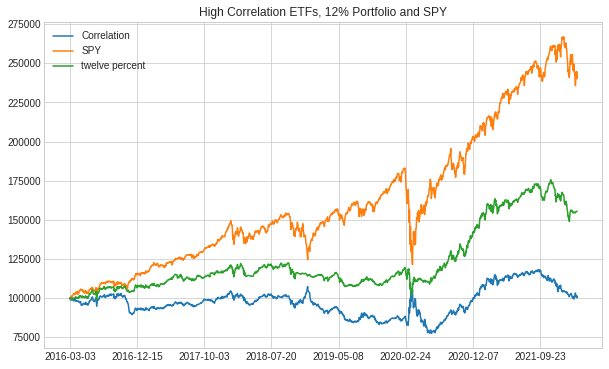

In [454]:
plot_df.plot(grid=True, title='High Correlation ETFs, 12% Portfolio and SPY', figsize=(10,6))

<h3>
Standard Error of the Correlation
</h3>

<p>
The ETF rotation algorithm is based on ETF momentum where the return in the current month
is predicted by the return in the previous three months.  The correlation between the
three month return and the one month return should be a measure of momentum.  An ETF
with high correlation should perform better than an ETF with low correlation.
</p>
<p>
This is not what we see in the previous plot, where the "high correlation" portfolio
performs much worse than the 12% portfolio or SPY.  A reason for this may be that the
correlation estimates contain significant error.
</p>
<p>
A sliding three month window is used to calcuate the return over the past three months.
The return over the month that follows this window is the one month return.  A correlation is
calculated for the three month return and the one month return.
</p>
<p>
The correlation data used to select the "high correlation" ETF set contains 8 x 12 = 96
return values in eight year time period from March 2008 to
March 2016.
</p>
<p>
There is some controversy about the proper equation to use to calculate the standard
error of the correlation. For example, see this Stack Exchange
<a href="https://stats.stackexchange.com/questions/73621/standard-error-from-correlation-coefficient">post</a>.
</p>
<p>
Two equations are proposed for calculating the standard error of the correlation.
The results are very similar for the correlation values that are calculated here.
</p>

$\ Corr_{se} = \sqrt{ \frac{1 - r^2}{N-2} } \approx \frac{1 - r^2}{\sqrt{N}}$

<p>
Here <i>r</i> is the correlation coefficient.
</p>
<p>
The standard error values fall within a narrow range, so it is reasonable to take
the average value.
</p>

In [455]:
return_corr_a = return_corr.values
# https://stats.stackexchange.com/questions/73621/standard-error-from-correlation-coefficient
n = three_month_df.shape[0]
corr_se_1 = sqrt((1 - return_corr_a**2)/(n-2))
corr_se_2 = (1 - return_corr_a**2)/sqrt(n-2)

print(f'Correlation standard error: mean, equation 1 = {round(corr_se_1.mean(), 4)}, mean equation 2 = {round(corr_se_2.mean(), 4)}')

Correlation standard error: mean, equation 1 = 0.1029, mean equation 2 = 0.1026


<p>
The standard error of the correlation is approximately
</p>

$ \mp 0.10$

<p>
This error is about the size of the top five correlation values, which suggests that
the correlation values cannot be relied on.
</p>

In [456]:

three_month_df, one_month_df = calculate_return_series(close_prices_df=all_etf_adj_close, start_date=start_date)
return_corr = three_month_df.corrwith(one_month_df)
return_corr.sort_values(ascending=False, inplace=True)
return_corr_df = pd.DataFrame(return_corr)

return_corr_a = return_corr.values
# https://stats.stackexchange.com/questions/73621/standard-error-from-correlation-coefficient
n = three_month_df.shape[0]
corr_se_1 = sqrt((1 - return_corr_a**2)/(n-2))
corr_se_2 = (1 - return_corr_a**2)/sqrt(n-2)

<h3>
ETF Correlations from 2008 to Present
</h3>

<p>
Many of the ETFs have an inception date in the third quarter of 2007.  Calculating
the three month and one month return correlation over this entire time period
yields a correlation with a smaller standard error.
</p>

In [457]:
print(tabulate(return_corr_df, headers=['Correlation'], tablefmt='fancy_grid'))

print('\n')
print(f'Number of returns used to calculate the correlations: {n}')

print(f'Correlation standard error: mean equation 1 = {round(corr_se_1.mean(), 4)}, mean equation 2 = {round(corr_se_2.mean(), 4)}')

╒══════╤═══════════════╕
│      │   Correlation │
╞══════╪═══════════════╡
│ VHT  │     0.175117  │
├──────┼───────────────┤
│ VCR  │     0.174285  │
├──────┼───────────────┤
│ VBR  │     0.162638  │
├──────┼───────────────┤
│ IWM  │     0.154411  │
├──────┼───────────────┤
│ VDC  │     0.152855  │
├──────┼───────────────┤
│ MDY  │     0.123539  │
├──────┼───────────────┤
│ SPY  │     0.11208   │
├──────┼───────────────┤
│ SDS  │     0.100089  │
├──────┼───────────────┤
│ VGT  │     0.0902223 │
├──────┼───────────────┤
│ QQQ  │     0.0884813 │
├──────┼───────────────┤
│ XLE  │     0.0851499 │
├──────┼───────────────┤
│ VUG  │     0.0849125 │
├──────┼───────────────┤
│ FXZ  │     0.0839313 │
├──────┼───────────────┤
│ RWM  │     0.0740178 │
├──────┼───────────────┤
│ VFH  │     0.0451232 │
├──────┼───────────────┤
│ SOXX │     0.0366648 │
├──────┼───────────────┤
│ SHY  │    -0.203224  │
╘══════╧═══════════════╛


Number of returns used to calculate the correlations: 168
Correlation sta

<p>
A backtest attempts to simulate a result from some point in the past.  We cannot use
the more accurate correlation estimates in the backtest because we would not have had
these values in in the past (in 2016, for example).
</p>
<p>
We could use the more accurate correlation values going forward from our current time,
but we don't know whether using a subset of the ETFs ranked by their correlation value
would yield better results.
</p>

<h2>
Portfolio with Drawdown
</h2>

<p>
The portfolio outlined in <i>The 12% Solution</i> is described as a long term investment
portfolio.  The risk adjusted results are excellent. Someone who was fortunate enough to
invest in 2008 would have seen their money grow by over 300%.
</p>
<p>
This section looks at the <i>The 12% Solution</i> portfolio from an income point of view.
The backtests here and in <i>The 12% Solution</i> show that the portfolio returns over
11%, on average, per year.  How would the portfolio perform if 10% of the portfolio
were withdrawn for current income in the case where the portfolio current portfolio
balance is at least equal to the initial capital plus ten percent.
</p>

╒════════════╤══════════════╕
│            │   Withdrawal │
╞════════════╪══════════════╡
│ 2009-12-03 │      14839.3 │
├────────────┼──────────────┤
│ 2010-12-03 │      14284   │
├────────────┼──────────────┤
│ 2011-12-02 │      13783.4 │
├────────────┼──────────────┤
│ 2012-12-03 │      13176.2 │
├────────────┼──────────────┤
│ 2013-12-03 │      14085.3 │
├────────────┼──────────────┤
│ 2014-12-03 │      15015   │
├────────────┼──────────────┤
│ 2015-12-03 │      13540.4 │
├────────────┼──────────────┤
│ 2016-12-02 │      12233.3 │
├────────────┼──────────────┤
│ 2017-12-01 │      12054.4 │
├────────────┼──────────────┤
│ 2020-12-03 │      13493.7 │
├────────────┼──────────────┤
│ 2021-12-03 │      13802.1 │
╘════════════╧══════════════╛


<AxesSubplot:title={'center':'Portfolio with 10% withdrawal'}, xlabel='Date'>

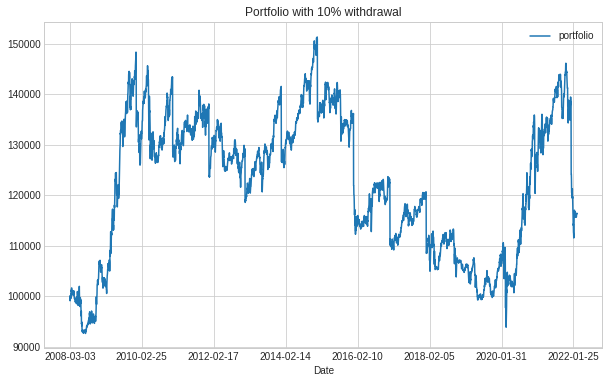

In [458]:
def portfolio_income(holdings: float,
                     asset_percent: float,
                     bond_percent: float,
                     asset_etfs: pd.DataFrame,
                     bond_etfs: pd.DataFrame,
                     start_date: datetime,
                     end_date: datetime,
                     withdraw_percent: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    asset_holding= holdings * asset_percent
    bond_holding=holdings * bond_percent
    back_delta = relativedelta(months=3)
    forward_delta = relativedelta(months=1)
    date_index = asset_etfs.index
    start_date_i = start_date
    current_year = start_date.year
    portfolio_a = np.zeros(0)
    last_index = 0
    cash_l = list()
    year_index_l = list()
    while start_date_i <= end_date:
        # Start of the back-test data
        back_start = start_date_i - back_delta
        # End of the backtest data
        back_end = start_date_i
        # end of the forward data period (e.g., one month)
        forward_end = start_date_i + forward_delta
        start_ix = findDateIndex(date_index, back_start)
        end_ix = findDateIndex(date_index, back_end)
        forward_ix = findDateIndex(date_index, forward_end)
        if start_ix >= 0 and end_ix >= 0 and forward_ix >= 0:
            # Choose an asset based on the past three months
            asset_df = chooseAsset(start=start_ix, end=end_ix, asset_set=asset_etfs)
            asset_month_df = asset_df[:][end_ix:forward_ix]
            asset_return_df = return_df(asset_month_df)
            bond_df = chooseAsset(start=start_ix, end=end_ix, asset_set=bond_etfs)
            bond_month_df = bond_df[:][end_ix:forward_ix]
            bond_return_df = return_df(bond_month_df)
            port_asset_a = apply_return(asset_holding, asset_return_df)
            port_bond_a = apply_return(bond_holding, bond_return_df)
            port_total_a = port_asset_a + port_bond_a
            last_index = forward_ix
            start_date_i = forward_end
            if start_date_i.year > current_year:
                current_port_total = port_total_a[-1]
                withdrawal =  current_port_total * withdraw_percent
                if (current_port_total - withdrawal) >= holdings:
                    port_total_a[-1] = current_port_total - withdrawal
                    cash_l.append(withdrawal)
                    month_index = asset_month_df.index[0]
                    year_index_l.append(month_index)
                current_year = start_date_i.year
            portfolio_a = np.append(portfolio_a, port_total_a)
            asset_holding = port_total_a[-1] * asset_percent
            bond_holding = port_total_a[-1] * bond_percent
        else:
            break
    portfolio_df = pd.DataFrame(portfolio_a)
    portfolio_df.columns = ['portfolio']
    index_start = findDateIndex(date_index, start_date)
    date_index = asset_etfs.index
    portfolio_index = date_index[index_start:last_index]
    portfolio_df.index = portfolio_index
    cash_df = pd.DataFrame(cash_l)
    cash_df.index = year_index_l
    return portfolio_df, cash_df


portfolio_income_df, cash_df = portfolio_income(holdings=holdings,
                                         asset_percent=equity_percent,
                                         bond_percent=bond_percent,
                                         asset_etfs=asset_adj_close,
                                         bond_etfs=fixed_income_adjclose,
                                         start_date=start_date,
                                         end_date=end_date,
                                         withdraw_percent=0.10)


print(tabulate(cash_df, headers=['Withdrawal'], tablefmt='fancy_grid'))

portfolio_income_df.plot(grid=True, title='Portfolio with 10% withdrawal', figsize=(10,6))


<h4>
Disclaimer
</h4>
<p>
This notebook is not financial advice, investing advice, or tax advice.
The information in this notebook is for informational and recreational purposes only.
Investment products discussed (ETFs, mutual funds, etc.) are for illustrative purposes
only. This is not a recommendation to buy, sell, or otherwise transact in any of the
products mentioned. Do your own due diligence. Past performance does not guarantee
future returns.
</p>